In [1]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
import requests
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


Load pre-trained inception model

In [2]:
inception_nn_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

Keras has the model definition built in

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                               include_top=False,  # This is to ignore the fully connected layer at the top of V3
                               weights=None)  # Do not use built in weights

We will use the weights we have jsut downloaded

In [4]:
cwd = os.getcwd()
print(cwd)

local_weights_file = os.path.join(cwd, 'inception_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
print(local_weights_file)

pre_trained_model.load_weights(local_weights_file)

C:\Users\LONAA32\Documents\Repos\coursera_tensorflow_in_practice\01_introduction_to_tensorflow
C:\Users\LONAA32\Documents\Repos\coursera_tensorflow_in_practice\01_introduction_to_tensorflow\inception_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


#### Now that we have loaded the data, we can iterate through the layers and lock them

In [5]:
layers = pre_trained_model.layers

In [6]:
for layer in layers:
    layer.trainable = False
    
# pre_trained_model.summary()

In [7]:
last_layer = layers[-1]
last_layer

In [8]:
last_output = last_layer.output
last_output

<tf.Tensor 'mixed10/Identity:0' shape=(None, 3, 3, 2048) dtype=float32>

This layer is convolved to a 3x3 but we need to find something a little bit bigger.

In [9]:
last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output
last_output

<tf.Tensor 'mixed7/Identity:0' shape=(None, 7, 7, 768) dtype=float32>

Now we need to define our new model taking the outputs from our inception model.

In [10]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Add a dropout layer to avoid overfitting (drop 20%)
x = tf.keras.layers.Dense(1, activation="sigmoid")(x)

In [11]:
model = Model(pre_trained_model.input, x)

In [12]:
model.compile(optimizer=RMSprop(lr=0.0001),
              loss="binary_crossentropy",
              metrics=["acc"])

Load data

In [13]:
base_dir = os.path.join(cwd, 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [14]:
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
class myCallback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')<0.05):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()

In [16]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=1,
      callbacks=[callback])

Epoch 1/100
100/100 [==============================] - 46s 457ms/step - loss: 0.3494 - acc: 0.8660 - val_loss: 0.1009 - val_acc: 0.9600
Epoch 2/100
100/100 [==============================] - 45s 454ms/step - loss: 0.2055 - acc: 0.9215 - val_loss: 0.1275 - val_acc: 0.9510
Epoch 3/100
100/100 [==============================] - 46s 458ms/step - loss: 0.2119 - acc: 0.9210 - val_loss: 0.1773 - val_acc: 0.9500
Epoch 4/100
100/100 [==============================] - 46s 463ms/step - loss: 0.1933 - acc: 0.9320 - val_loss: 0.1155 - val_acc: 0.9580
Epoch 5/100
100/100 [==============================] - 47s 467ms/step - loss: 0.1915 - acc: 0.9405 - val_loss: 0.1463 - val_acc: 0.9550
Epoch 6/100
100/100 [==============================] - 47s 465ms/step - loss: 0.1814 - acc: 0.9365 - val_loss: 0.1073 - val_acc: 0.9670
Epoch 7/100
100/100 [==============================] - 46s 463ms/step - loss: 0.1586 - acc: 0.9450 - val_loss: 0.1200 - val_acc: 0.9590
Epoch 8/100
100/100 [===========================

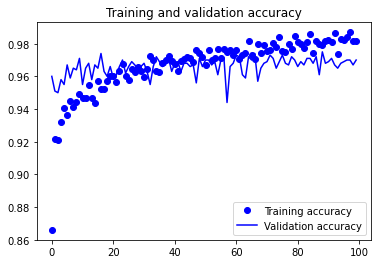

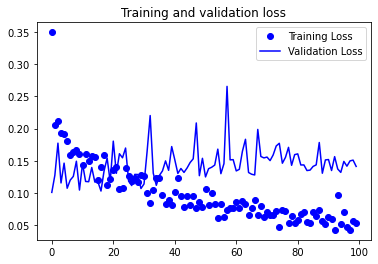

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Save model

In [19]:
model.save('saved_model/my_model_inception') 

INFO:tensorflow:Assets written to: saved_model/my_model_inception\assets


Load model

In [27]:
model_path = os.path.join(cwd, "saved_model/my_model_inception")
model = tf.keras.models.load_model(model_path)

In [36]:
path = os.path.join(cwd, "sample_photos", "dog_1.jpg")
#path = os.path.join(cwd, "sample_photos", "cat.jpg")
#path = os.path.join(cwd, "sample_photos", "shiba_1.jpg")

img = tf.keras.preprocessing.image.load_img(path, target_size=(150, 150))

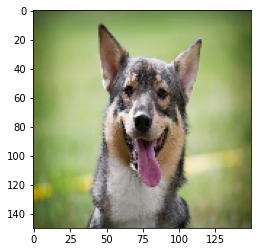

In [37]:
plt.imshow(img)

In [38]:
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)  # Add a unit dimension at the front

In [39]:
# Make prediction
classes = model.predict(x, batch_size=0)
if classes[0] > 0:
    print("Dog")
else:
    print("Cat")

Cat
